## Plot the generated daily soil and runoff cation concentrations

user_nl_elm specs: 
```
 hist_mfilt = 1, 1
 hist_nhtfrq = -96360, -24
 hist_dov2xy = .true., .true.
 hist_fincl2 = 'soil_pH', 'forc_app', 'forc_min', 'forc_pho', 'forc_gra', 'forc_sph',
            'primary_mineral_vr_1', 'cation_vr_1', 'cation_vr_2', 'cation_vr_3', 'cation_vr_4', 'cation_vr_5', 'silica_vr',
            'secondary_mineral_vr_1', 'armor_thickness_vr', 'ssa', 
            'primary_mineral', 'cation', 'silica', 'secondary_mineral', 
            'primary_added_vr_1', 'primary_dissolve_vr_1', 'primary_proton_flux_vr',
            'primary_h2o_flux_vr', 'primary_cation_flux_vr_1', 'r_dissolve_vr_1',
            'secondary_cation_flux_vr_1', 'secondary_mineral_flux_vr_1', 'r_precip_vr_1',
            'primary_prelease_vr', 'cation_leached_vr_1', 'cation_runoff_vr_1',
            'primary_added', 'primary_dissolve', 'primary_cation_flux',
            'secondary_cation_flux', 'secondary_mineral_flux', 'cation_leached',
            'cation_runoff', 'r_sequestration', 'background_weathering', 'background_weathering_vr_1'
```

In [1]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams

folder = 'ERW_20240310_HBR_1_ICB20TRCNPRDCTCBC'
#folder = 'ERW_20231110_UC_Davis_ICB20TRCNPRDCTCBC'

rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18

In [2]:
path_to_files = os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', folder, 'run')
hr = xr.open_mfdataset(glob(os.path.join(path_to_files, '*.elm.h1.*.nc')))
tvec = [pd.Timestamp(year=t.year, month=t.month, day=t.day) for t in hr['time'].values]

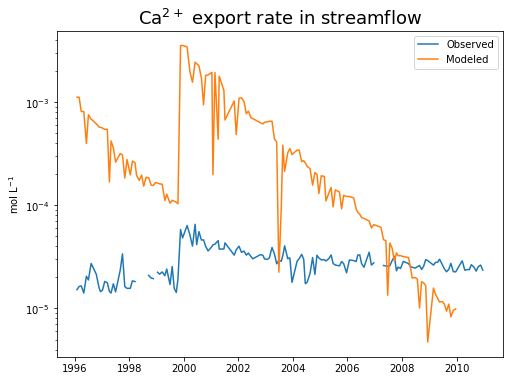

In [3]:
# cation_export_obs = convert_streamChem(read_streamChem())
cation_export_obs = read_streamChem() * 1e-6 # umol/L -> mol/L

cation_export_sim = pd.DataFrame(
    (hr['cation_leached'][:, :, 0] + hr['cation_runoff'][:, :, 0]) / \
    (hr['QRUNOFF'] + hr['QDRAI'])[:,0].values.reshape(-1,1),
    index = tvec, columns = ['Ca2+','Mg2+','Na+','K+','Al3+'])

cation_export_sim = cation_export_sim.loc[
    cation_export_obs.index.intersection(cation_export_sim.index), :]

cation_export_obs = cation_export_obs.loc[
    (cation_export_obs.index.year >= 1996) & 
    (cation_export_obs.index.year <= 2010)]
cation_export_sim = cation_export_sim.loc[
    (cation_export_sim.index.year >= 1996) & 
    (cation_export_sim.index.year <= 2010), :]

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(cation_export_obs['Ca2'].index, cation_export_obs['Ca2'], label = 'Observed')
ax.plot(cation_export_sim['Ca2+'].index, cation_export_sim['Ca2+'] / 40, label = 'Modeled')
ax.set_xlabel('')
ax.set_ylabel('mol L$^{-1}$')
ax.set_yscale('log')
ax.legend()
ax.set_title('Ca$^{2+}$ export rate in streamflow')
plt.savefig('./temp/hbr_cation_export.png', dpi = 600., bbox_inches = 'tight')

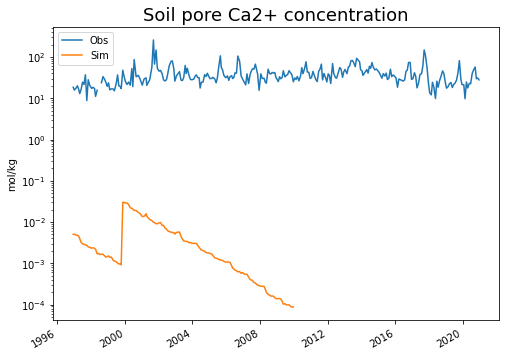

In [8]:
soil_pore_obs = read_lysimeter()

# calcium: convert from g m-3 soil to mol/kg porewater
soil_pore_sim = pd.Series( 
    ((hr['cation_vr_1'][:,:6,0] / hr['H2OSOI'][:,:6,0] / 40 / 1000) *
     hr['levgrnd'].values[:6].reshape(1,-1)).sum(axis = 1) / hr['levgrnd'].values[:6].sum(), 
     index = tvec)

soil_pore_sim = soil_pore_sim.loc[
    soil_pore_sim.index.intersection(soil_pore_obs.index)]

plt.figure(figsize = (8,6))
soil_pore_obs['Ca2+'].plot(label = 'Obs')
soil_pore_sim.plot(label = 'Sim')
plt.xlabel('')
plt.ylabel('mol/kg')
plt.yscale('log')
plt.legend()
plt.title('Soil pore Ca2+ concentration')
plt.savefig('./temp/hbr_soil_pore_water.png', dpi = 600., bbox_inches = 'tight')

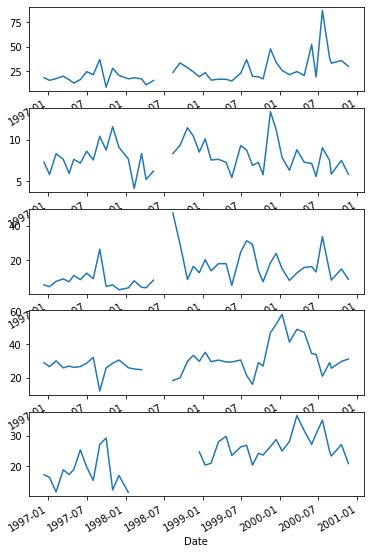

In [21]:
fig, axes = plt.subplots(5, 1, figsize = (6, 10))
for i, cation in enumerate(['Ca2+', 'Mg2+', 'K+', 'Na+', 'Alt']):
    ax = axes.flat[i]
    soil_pore_obs.loc[(soil_pore_obs.index.year >= 1996) & \
                      (soil_pore_obs.index.year <= 2000), cation].plot(ax = ax)

In [5]:
# Calculate the total concentration of added cations as bicarbonate alkalinity
# (1) pre-treatment (pre-2019: bicarbonate alkalinity)
# (2) during-treatment (2019-autumn 2020)
# (3) post-treatment (winter 2020-2021)

zsoi = np.insert((hr['levgrnd'].values[:-1] + hr['levgrnd'].values[1:]) / 2, 0, 0)
zsoi = np.insert(zsoi, -1, hr['levgrnd'].values[-1] + 
                0.5 * (hr['levgrnd'].values[-1] - hr['levgrnd'].values[-2]))
thickness = np.diff(zsoi)

alkalinity = np.zeros([len(hr['time']), 2])

for i, mixing_depth in enumerate([0.15, 0.3]):
    weight = np.where(zsoi[:-1] < mixing_depth, np.minimum(thickness, mixing_depth - zsoi[:-1]), 0)
    for n in range(1,6):
        # keep the g m-3 unit = mg L-1
        temp = np.sum(hr[f'cation_vr_{n}'][:,:,0] * weight.reshape(1, -1), 
                      axis = 1) / np.sum(weight)
        if n in [1,2]:
            # Ca2+, Mg2+
            alkalinity[:, i] = alkalinity[:, i] + 2 * temp
        elif n in [3, 4]:
            alkalinity[:, i] = alkalinity[:, i] + temp
        else:
            alkalinity[:, i] = alkalinity[:, i] + 3 * temp


Text(0, 0.5, 'bicarbonate alkalinity')

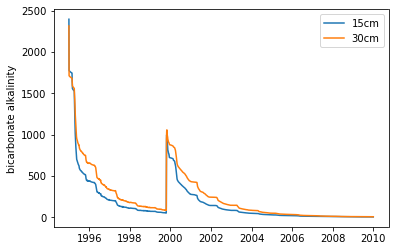

In [6]:
plt.plot(tvec, alkalinity)
plt.legend(['15cm', '30cm'])
plt.ylabel('bicarbonate alkalinity')

In [7]:
hr.close()